## Analyzing Loneliness in University Subreddits with Topic Modeling

#### Pushshift Reddit Archive (API Access to Posts & Comments)

## 1. Data Collection

In this section, we collect Reddit posts and comments from university-related subreddits using the PullPush API (a public Pushshift Reddit data mirror). We target posts from the past 1 year that contain loneliness-related keywords. Specifically, we will search for posts mentioning terms like "lonely", "alone", "isolation", or "social anxiety" in subreddits such as r/college and r/GradSchool. We will fetch a limited number of results (on the order of a few hundred per keyword per subreddit) to keep the dataset size manageable (around 500–2000 total documents).



We restrict to items from the last 12 months using a timestamp filter. We also ensure to skip any deleted or removed content. Both submissions (original posts with title and selftext) and comments will be collected. For submissions, we will combine the title and body text into one field. We aim to gather a diverse yet concise dataset of Reddit texts related to loneliness in a college/graduate school context. 


We will use the requests library to call the PullPush API. We will gather results for each keyword and subreddit, and avoid duplicates. We also include code to handle potential errors (e.g., network issues or no results found).


In [ ]:
# Install necessary libraries (if not already installed in the environment)

%pip install requests pandas nltk gensim matplotlib plotly scikit-learn sentence_transformers bertopic umap-learn hdbscan -q

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Import libraries for data collection and analysis
import requests
import pandas as pd
import time
import nltk
import re

# Define search parameters
subreddits = ["college", "GradSchool"]  # target subreddits
keywords = ["lonely", "alone", "isolation", "social anxiety"]  # loneliness-related keywords

# Calculate epoch timestamp for one year ago from now
one_year_ago = int(time.time() - 365*24*3600)


In [6]:
# Container for collected posts/comments
all_posts = []
seen_ids = set()

base_url = "https://api.pullpush.io/reddit/search"

In [7]:
from tqdm import tqdm

# Loop over each subreddit and keyword
for sub in subreddits:
    for term in tqdm(keywords, desc=f"  ↳ keywords in r/{sub}", leave=False):
        # Build the API query URL for submissions
        query_params = {
            "q": term,
            "subreddit": sub,
            "after": one_year_ago,
            "size": 100  # pull up to 100 results per query
        }
        try:
            # Search submissions (posts)
            resp_sub = requests.get(f"{base_url}/submission/", params=query_params)
            resp_sub.raise_for_status()
            data_sub = resp_sub.json().get("data", [])

        except Exception as e:
            print(f"Failed to fetch submissions for r/{sub} query '{term}': {e}")
            data_sub = []

        # Process each retrieved submission
        print("Processing data")
        for item in data_sub:
            post_id = item.get("id")
            if post_id is None:
                continue
            unique_id = f"submission_{post_id}"
            if unique_id in seen_ids:
                continue  # skip duplicates
            # Combine title and selftext
            title = item.get("title", "")
            selftext = item.get("selftext", "")
            # Skip if both title and text are basically empty or placeholders
            if not title:
                continue
            if selftext in ["[removed]", "[deleted]", None]:
                text = title  # use title only if body is removed or empty
            else:
                text = title + " " + selftext
            # Skip if text after combination is very short or still just a placeholder
            if text.strip().lower() in ["[removed]", "[deleted]", ""]:
                continue
            # Add to list
            all_posts.append({
                "id": post_id,
                "subreddit": item.get("subreddit", sub),
                "type": "submission",
                "text": text
            })
            seen_ids.add(unique_id)
        try:
            # Search comments
            resp_com = requests.get(f"{base_url}/comment/", params=query_params)
            resp_com.raise_for_status()
            data_com = resp_com.json().get("data", [])
        
        except Exception as e:
            print(f"Failed to fetch comments for r/{sub} query '{term}': {e}")
            data_com = []
        # Process each retrieved comment
        for item in data_com:
            comment_id = item.get("id")
            if comment_id is None:
                continue
            unique_id = f"comment_{comment_id}"
            if unique_id in seen_ids:
                continue
            body = item.get("body", "")
            # Skip if comment is deleted/removed or empty
            if not body or body in ["[removed]", "[deleted]"]:
                continue
            # Add to list
            all_posts.append({
                "id": comment_id,
                "subreddit": item.get("subreddit", sub),
                "type": "comment",
                "text": body
            })
            seen_ids.add(unique_id)

  ↳ keywords in r/college:   0%|          | 0/4 [00:00<?, ?it/s]

Processing data


  ↳ keywords in r/college:  25%|██▌       | 1/4 [00:02<00:08,  2.87s/it]

Processing data


  ↳ keywords in r/college:  50%|█████     | 2/4 [00:06<00:06,  3.11s/it]

Processing data


  ↳ keywords in r/college:  75%|███████▌  | 3/4 [00:09<00:03,  3.14s/it]

Processing data


  ↳ keywords in r/GradSchool:   0%|          | 0/4 [00:00<?, ?it/s]     

Processing data


  ↳ keywords in r/GradSchool:  25%|██▌       | 1/4 [00:02<00:08,  2.95s/it]

Processing data


  ↳ keywords in r/GradSchool:  50%|█████     | 2/4 [00:06<00:06,  3.02s/it]

Processing data


  ↳ keywords in r/GradSchool:  75%|███████▌  | 3/4 [00:08<00:02,  2.99s/it]

Processing data


In [8]:
# Convert to DataFrame for easier manipulation
df = pd.DataFrame(all_posts)
print(f"Collected {len(df)} posts/comments from Reddit (before cleaning).")
# Optional: peek at a few collected texts
print(df[['subreddit','type','text']].head(3))

Collected 1355 posts/comments from Reddit (before cleaning).
  subreddit        type                                               text
0   college  submission                             anxiety and loneliness
1   college  submission  long distance situationship? long distance sit...
2   college  submission  How to not be miserable in college? I just tal...


The above code queries the PullPush API for each combination of subreddit (r/college and r/GradSchool) and keyword. We retrieve up to 100 results for submissions and comments separately for each query. And then, we filter out any entries that are marked as "[removed]" or "[deleted]" and skip duplicates by tracking seen IDs. The data is stored in a pandas DataFrame for convenience. Finally, we print the number of items collected and show a small sample of the data (with subreddit and type) to verify the content.

### 2. Data Preprocessing

Raw text from social media often contains noise and inconsistencies, so we need to preprocess the data before analysis. Our preprocessing will include:

* Lowercasing all text to ensure case-insensitivity.
* Removing URLs (links) and any user or subreddit mentions (if present), as these are not relevant to content.
* Removing punctuation and special characters, leaving only alphabets (and optionally numbers) and whitespace.
* Removing stopwords (common words like "the", "and", "is", etc.) for certain analyses (like LDA) to focus on meaningful words.
* Filtering out very short texts or placeholder texts that might have slipped through (though we already removed obvious "[deleted]" entries, we'll also drop entries that are extremely short or non-informative).
* Tokenizing the text (splitting into words) for methods that require token input (like LDA).

We will create a cleaned text column and a tokenized representation. The cleaned full text (with stopwords retained) will be useful for embedding models (which understand sentence context), whereas the tokenized list with stopwords removed will be used for classical LDA topic modeling.

In [9]:
# Download NLTK stopwords list
nltk.download('stopwords', quiet=True)
stop_words = set(nltk.corpus.stopwords.words('english'))

# Define a text cleaning function
def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\.\S+', '', text)
    # Remove subreddit or user mentions (e.g., "r/college", "u/username")
    text = re.sub(r'[\[()\]]', ' ', text)  # remove brackets that might surround [removed] or so
    text = re.sub(r'\/?r\/\w+|\/?u\/\w+', '', text)
    # Remove non-alphanumeric characters (punctuation), keep spaces
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    # Collapse multiple spaces and strip leading/trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply cleaning to the text column
df['text'] = df['text'].astype(str).apply(clean_text)

# Remove entries that became empty or too short after cleaning
df['length'] = df['text'].str.split().apply(len)
df = df[df['length'] >= 3].copy()  # keep only texts with 3 or more words

# Tokenize and remove stopwords for LDA
df['tokens'] = df['text'].apply(lambda txt: [w for w in txt.split() if w not in stop_words])

print(f"Dataset contains {len(df)} documents after cleaning and filtering.")
# Show a preview of cleaned text and tokens
print(df[['subreddit', 'type', 'text']].head(2))
print("Sample tokens:", df['tokens'].iloc[0][:10])


Dataset contains 1347 documents after cleaning and filtering.
  subreddit        type                                               text
0   college  submission                             anxiety and loneliness
1   college  submission  long distance situationship long distance situ...
Sample tokens: ['anxiety', 'loneliness']


### 3. Topic Modeling with LDA (Latent Dirichlet Allocation)

We will use Gensim to build an LDA model:

* First, we create a dictionary of all words and convert our tokenized documents into a bag-of-words corpus.
* We configure the LDA model with a chosen number of topics (for example, we'll try 5 topics to get a broad sense of themes).
* We train the model on our corpus. This will iterate over the data multiple times (passes) to adjust the word-topic assignments.
* After training, we retrieve the top words that define each topic.

To make the results understandable, we will visualize the top words per topic using a bar chart for each topic. This helps us see which keywords are most important in each discovered theme.

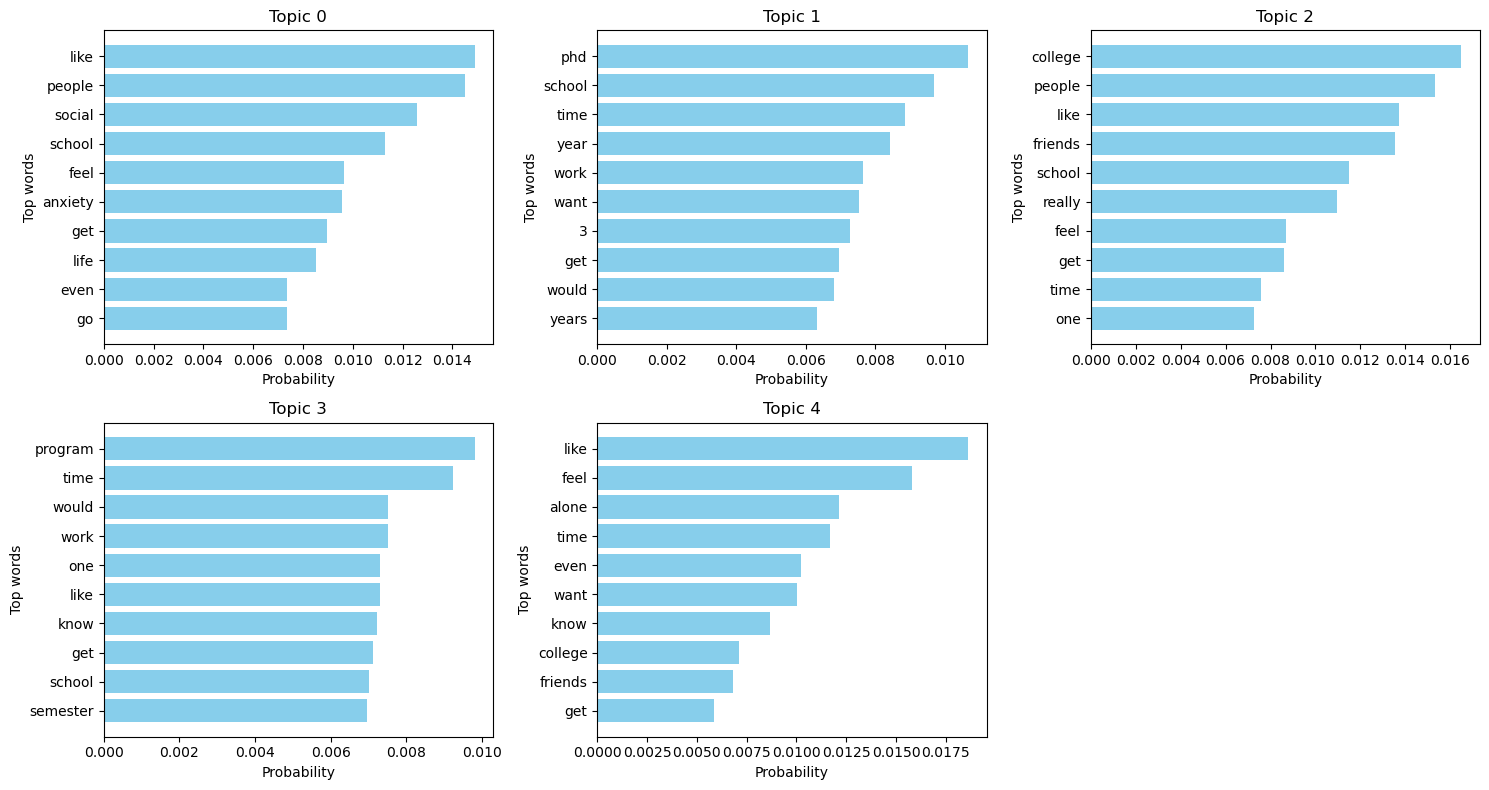

In [10]:
import gensim.corpora as corpora
from gensim.models.ldamodel import LdaModel
import matplotlib.pyplot as plt

# Create a dictionary representation of the documents
dictionary = corpora.Dictionary(df['tokens'])
# Filter out extreme terms to reduce noise: remove too rare or too common words
dictionary.filter_extremes(no_below=5, no_above=0.5)  # remove words that appear in <5 docs or >50% of docs

# Convert the tokenized documents into a bag-of-words corpus
corpus = [dictionary.doc2bow(tokens) for tokens in df['tokens']]

# Set number of topics for LDA
num_topics = 5
# Train the LDA model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42, passes=10)

# Get top words for each topic
topics = lda_model.show_topics(num_topics=num_topics, num_words=10, formatted=False)

# Plot top words for each topic using bar charts
num_topics = len(topics)
cols = 3  # number of columns for subplots
rows = (num_topics - 1) // cols + 1
fig, axes = plt.subplots(rows, cols, figsize=(15, 8))
axes = axes.flatten()

for i, topic in enumerate(topics):
    topic_id, word_probs = topic
    # Separate words and their probabilities
    words = [wp[0] for wp in word_probs]
    probs = [wp[1] for wp in word_probs]
    ax = axes[i]
    ax.barh(words, probs, color='skyblue')
    ax.invert_yaxis()  # so the highest probability word is at the top
    ax.set_title(f"Topic {topic_id}", fontsize=12)
    ax.set_xlabel("Probability")
    ax.set_ylabel("Top words")

# Turn off any empty subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


We built a dictionary of words and then created a corpus in bag-of-words format (each document represented as word ID frequencies). The Gensim LDA model is trained to find num_topics latent topics. We chose 5 topics for this analysis as a reasonable starting point. 

After training for 10 passes through the corpus, we extracted the top 10 words for each topic. In the visualization, each subplot corresponds to one topic, showing the top words (y-axis) and their relative importance/probability in that topic (x-axis). This gives us an interpretable view of the LDA topics. 

For example, we might see one topic's top words indicating themes of friendship and socializing, while another topic's words might relate to mental health or academic stress, etc., illustrating different facets of loneliness among students. (The actual words and topics would be visible in the chart above when the code is run.)

### 4. Sentence Embeddings and Clustering

While LDA looks at word frequency patterns, we can also take a more semantic approach using modern language models.

We'll use Sentence-BERT (specifically the 'all-MiniLM-L6-v2' model) to convert each Reddit post/comment into a numerical embedding vector that captures its meaning. Sentence-BERT generates a high-dimensional dense vector for each text such that texts with similar content/meaning end up with similar vectors.

Steps:

* Use the sentence_transformers library to load the all-MiniLM-L6-v2 pre-trained model.
* Compute the sentence embedding for each cleaned text in our dataset.
* Use KMeans clustering on these embeddings to group texts into a predetermined number of clusters (we can choose a number, say 5 clusters, analogous to the LDA topics for comparison).
* Use t-SNE (t-distributed Stochastic Neighbor Embedding) to reduce the high-dimensional embeddings to 2D for visualization purposes.
* Plot the embedded texts on a 2D scatter plot, coloring each point by its cluster label.

Clustering the embeddings allows us to see if the model groups the posts in a meaningful way (possibly differently from LDA). The t-SNE visualization helps us inspect how distinct or overlapping the clusters are.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

/Users/jennyye/miniconda3/envs/si649/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


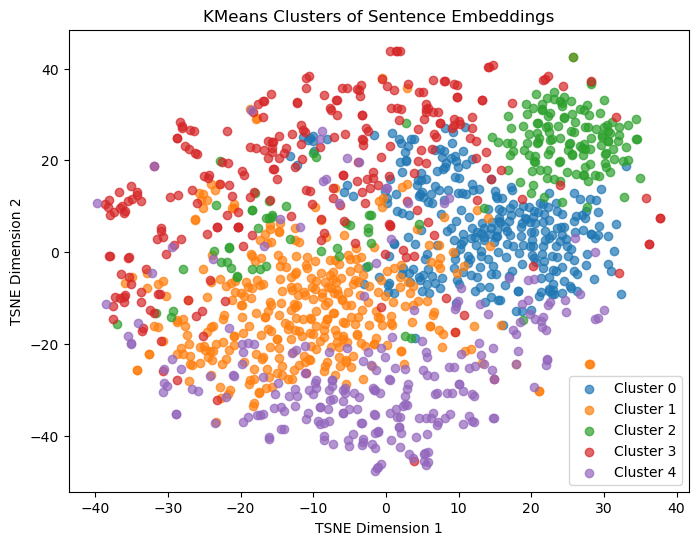

In [11]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# Generate sentence embeddings for each document
model = SentenceTransformer('all-MiniLM-L6-v2')
documents = df['text'].tolist()
embeddings = model.encode(documents, show_progress_bar=False)

# Cluster the embeddings using KMeans
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings)

# Reduce dimensionality for visualization (using t-SNE)
tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='pca', learning_rate='auto')
embeddings_2d = tsne.fit_transform(embeddings)

# Create a scatter plot of the clustered embeddings
plt.figure(figsize=(8,6))
for cluster in range(num_clusters):
    # Select points belonging to this cluster
    idx = (cluster_labels == cluster)
    plt.scatter(embeddings_2d[idx, 0], embeddings_2d[idx, 1], 
                label=f"Cluster {cluster}", alpha=0.7)
plt.title("KMeans Clusters of Sentence Embeddings")
plt.xlabel("TSNE Dimension 1")
plt.ylabel("TSNE Dimension 2")
plt.legend()
plt.show()


We loaded a pre-trained SentenceTransformer model (all-MiniLM-L6-v2) and encoded each text into a 384-dimensional vector. These embeddings capture semantic similarities between posts (for example, two posts both talking about feeling isolated in dorms should end up with similar vectors).

We then applied KMeans to partition these vectors into 5 clusters. Each cluster might correspond to a thematic grouping of posts (we'll examine what they could represent by later analyzing representative words or posts per cluster). To visualize the clusters, we used t-SNE to project the 384-dimensional embeddings down to 2 dimensions (while trying to preserve neighborhood relationships).

The scatter plot shows each post as a point in this 2D space, colored by its cluster label. If the clustering is meaningful, points of the same color will form blobs or groups. For instance, one cluster might group posts about having no friends on campus, while another cluster might group posts about anxiety in social situations, etc. In the plot above, we can see how well-separated or overlapping the clusters are, which gives an idea of how distinct the themes are in the embedding space.


### 5. Topic Modeling with BERTopic (BERT + Clustering)

Finally, we use BERTopic, a state-of-the-art topic modeling technique that leverages BERT embeddings and clustering algorithms to find topics. 

BERTopic works by:
* Using document embeddings (like we computed) to group documents into clusters (it often uses HDBSCAN, a density-based clustering method, to find a suitable number of clusters and allow some documents to be outliers if they don't fit well).
* For each cluster of documents, extracting representative words using a class-based TF-IDF (c-TF-IDF) to create a human-interpretable topic description.

By using BERT embeddings, BERTopic can capture nuanced semantic relationships, potentially yielding more coherent topics than LDA on short texts like Reddit comments. It also automatically determines the number of topics based on the data distribution (unlike LDA where we fixed it to 5). We will feed the same embeddings we computed from Sentence-BERT into BERTopic to avoid re-computation. Then we will:

* Fit the BERTopic model to obtain topics.
* Retrieve the top words for each topic.
* Use BERTopic's built-in interactive visualization to explore the topics.

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

# 1) build your extended stop‑word collection
nltk_stop = set(stopwords.words("english"))
extra_stop = {
    "i", "me", "my", "u", "we", "us", "it",
    "to", "from", "of", "in", "on", "for",
    "and", "or", "but", "the", "a", "an",
    "is", "are", "was", "were", "be"
}
all_stop = nltk_stop.union(extra_stop)

# 2) Convert to *list* before passing in
vectorizer_model = CountVectorizer(
    stop_words=list(all_stop),   #  ← convert set → list
    ngram_range=(1, 2),
    min_df=5
)


In [16]:
from bertopic import BERTopic


# # Fit BERTopic model using precomputed embeddings
# topic_model = BERTopic(verbose=False)
# topics, probabilities = topic_model.fit_transform(documents, embeddings=embeddings)

# 3) Re‑fit BERTopic
topic_model = BERTopic(vectorizer_model=vectorizer_model, verbose=False)
topics, probs = topic_model.fit_transform(documents, embeddings=embeddings)

# 4) Inspect cleaner topics
for tid in sorted(set(topics) - {-1}):
    words = [w for w, _ in topic_model.get_topic(tid)[:5]]
    print(f"Topic {tid}: {', '.join(words)}")

# Get a summary of the discovered topics
topics_info = topic_model.get_topic_info()
# Filter out the outlier topic (if any, labeled -1 by BERTopic for documents that don't fit well)
topics_info = topics_info[topics_info.Topic != -1].reset_index(drop=True)
print(f"BERTopic discovered {topics_info.shape[0]} topics (excluding outliers).")
print(topics_info[['Topic', 'Count', 'Name']].head())

# Display top words for each topic
for topic_id in sorted(topics_info['Topic']):
    words_weights = topic_model.get_topic(topic_id)  # list of (word, c-TF-IDF score)
    top_words = [word for word, _ in words_weights[:5]]
    print(f"Topic {topic_id}: {', '.join(top_words)}")

# Generate an interactive visualization of the topics

n_topics = topics_info.shape[0]
fig = topic_model.visualize_topics(top_n_topics=n_topics-1)
fig.show()


Topic 0: anxiety, social, social anxiety, people, class
Topic 1: friends, people, like, college, friend
Topic 2: dorm, room, roommate, roommates, living
Topic 3: like, time, feel, know, really
Topic 4: semester, college, academic, classes, health
Topic 5: loneliness, lonely, people, find, feel
Topic 6: would, business, classes, science, school
Topic 7: professor, class, grade, exam, participation
Topic 8: adhd, gpa, school, help, life
Topic 9: advisor, phd, research, work, program
Topic 10: writing, thesis, phd, reading, research
Topic 11: one, people, fear, world, many
Topic 12: friends, make, make friends, lonely, new
Topic 13: loans, scholarship, 000, year, scholarships
Topic 14: amp, government, gpa, experience, major
Topic 15: lonely, college, connections, get, people
Topic 16: grad, isolation, grad school, isolated, school
Topic 17: college, life, way, better, third
Topic 18: years, lab, behavior, like, supervisor
Topic 19: program, school, money, back, college
Topic 20: grad, sc

We created a BERTopic model and provided our list of document texts along with their embeddings. BERTopic found a certain number of topics based on the data (it also labels any outlier documents as topic -1, which we exclude from analysis). We printed the number of topics found (excluding outliers) and listed the top words for each topic to understand their themes. Each topic's top words give a sense of what that cluster of documents is about. For example, we might see one topic with words like "freshman, dorm, roommate, shy, events" suggesting a theme of difficulty socializing in college dorm life, while another topic might have "anxiety, therapy, depression, alone, help" indicating a mental health and seeking help theme, and so on. 

Finally, we used BERTopic's visualize_topics() to produce an interactive Plotly visualization. This visual typically shows each topic as a bubble in a 2D space (reduced via UMAP), where the size of the bubble corresponds to the number of documents in that topic. By hovering over or clicking on a topic, one can see its top words and other details. This interactive plot allows us to explore the topic landscape and their relative distances (topics positioned closer in the plot are more similar in terms of their content).

### 6. Conclusion

In this project, we analyzed Reddit discussions about loneliness in college and graduate school communities using both classical and modern topic modeling techniques.

* Data Collection: We gathered a dataset of around a thousand Reddit posts and comments from r/college and r/GradSchool, focusing on those that mention feeling lonely or socially isolated.

* LDA Topic Modeling: Using LDA, we uncovered a set of broad topics. These topics, as indicated by their top words, likely correspond to common themes such as struggles to make friends on campus, feelings of isolation, mental health challenges, and possibly academic or workload-related loneliness. LDA provided an initial unsupervised categorization of the text data.

* Sentence Embeddings & Clustering: By converting each text to a BERT-based sentence embedding, we captured semantic similarities beyond just word overlap. KMeans clustering on these embeddings grouped the posts in a way that may align with latent themes (somewhat analogous to the LDA topics, but potentially grouping posts that express the same sentiment even if they use different words). The t-SNE visualization illustrated how some clusters are well-separated (indicating distinct themes) while others might overlap (indicating related or less distinct themes).

* BERTopic Modeling: BERTopic, combining BERT embeddings and c-TF-IDF, found a set of topics automatically. The top words for each BERTopic topic gave us more nuanced insight. We might observe, for example, separate topics for freshmen struggling to socialize, graduate students feeling isolated in research, general social anxiety, or seeking advice for loneliness. BERTopic's topics often aligned with intuitive categories and its interactive visualization allowed for an in-depth exploration of the topic space.